In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


from PIL import Image
import glob
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import pickle
import cv2
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
from PIL import Image

## 데이터 준비

In [3]:
def resize_images(img_path):
    images=glob.glob(img_path + "/*.jpg")  
    
    print(len(images), " images to be resized.")

    # 파일마다 모두 128x128 사이즈로 바꾸어 저장합니다.
    target_size=(128,128)
    for img in images:
        old_img=Image.open(img)
        new_img=old_img.resize(target_size,Image.ANTIALIAS)
        new_img.save(img, "JPEG")
    
    print(len(images), " images resized.")

image_dir_path = 'rock_scissor_paper/data/scissor'
resize_images(image_dir_path)

100  images to be resized.
100  images resized.


In [4]:
#바위

image_dir_path ='rock_scissor_paper/data/rock'
resize_images(image_dir_path)

100  images to be resized.
100  images resized.


In [5]:
# 보
image_dir_path = 'rock_scissor_paper/data/paper'
resize_images(image_dir_path)

100  images to be resized.
100  images resized.


In [6]:
import numpy as np

def load_data(img_path, number_of_data=300):
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=128
    
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("학습데이터(x_train)의 이미지 개수는", idx,"입니다.")
    return imgs, labels

image_dir_path = "rock_scissor_paper/data"
(x_train, y_train)=load_data(image_dir_path)
x_train_norm = x_train/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))

학습데이터(x_train)의 이미지 개수는 300 입니다.
x_train shape: (300, 128, 128, 3)
y_train shape: (300,)


라벨:  1


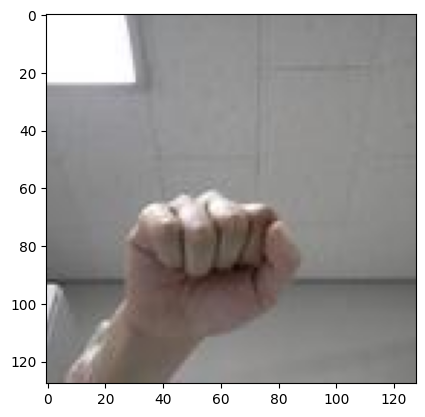

In [7]:
plt.imshow(x_train[101])
print('라벨: ', y_train[101])

## 픽셀값 분포 확인

In [8]:
def draw_color_histogram_from_image(file_name):
    image_path = file_name
    # 이미지 열기
    img = Image.open(image_path)
    cv_image = cv2.imread(image_path)

    # Image와 Histogram 그려보기
    f=plt.figure(figsize=(10,3))
    im1 = f.add_subplot(1,2,1)
    im1.imshow(img)
    im1.set_title("Image")

    im2 = f.add_subplot(1,2,2)
    color = ('b','g','r')
    for i,col in enumerate(color):
        # image에서 i번째 채널의 히스토그램을 뽑아서(0:blue, 1:green, 2:red)
        histr = cv2.calcHist([cv_image],[i],None,[256],[0,256])   
        im2.plot(histr,color = col)   # 그래프를 그릴 때 채널 색상과 맞춰서 그립니다.
    im2.set_title("Histogram")

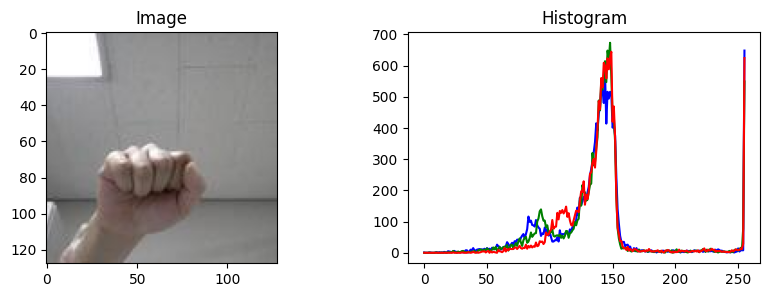

In [9]:
draw_color_histogram_from_image('rock_scissor_paper/data/rock/0.jpg')

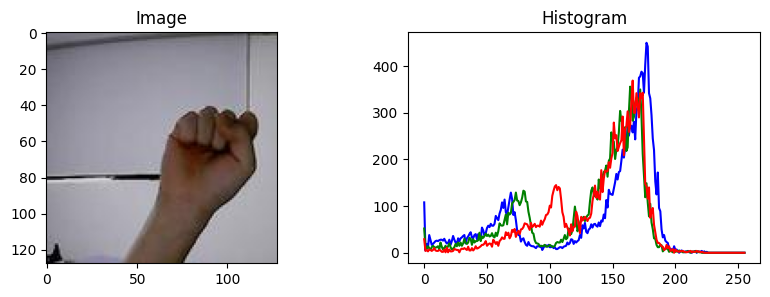

In [10]:
draw_color_histogram_from_image('rock_scissor_paper/test/rock/0.jpg')

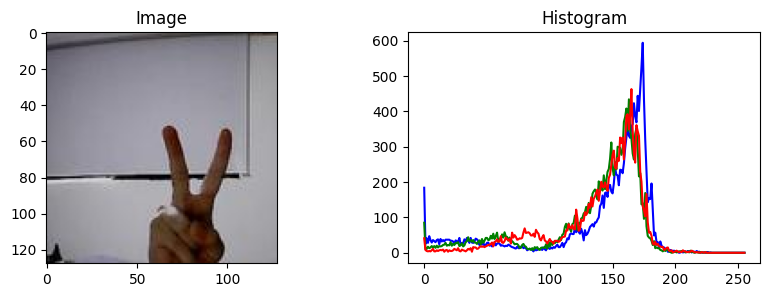

In [11]:
draw_color_histogram_from_image('rock_scissor_paper/test/scissor/0.jpg')

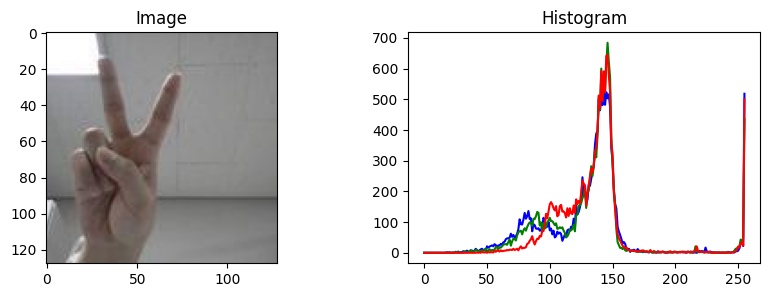

In [12]:
draw_color_histogram_from_image('rock_scissor_paper/data/scissor/0.jpg')

## 데이터 증강(data augmentation)

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd

aug_generator = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.1,
    zoom_range = 0.1,
    horizontal_flip = True,
    fill_mode = 'nearest' # 회전시 공백이 발생되는데 가까운 값으로 채움
    )
'''
# directory로 넣어줄 때
train_aug_generator = aug_generator.flow(
    image_dir_path,
    target_size = (224,224),    
    batch_size = 100,
    class_mode ='sparse'  # 정답 십진수 형태    
)
'''

augmentation_ratio = 2.0
augment_size = int(augmentation_ratio * x_train.shape[0])      # 원본데이터의 ratio 배만큼 만들어줌
randidx = np.random.randint(x_train.shape[0], size=augment_size)

x_augmented = x_train[randidx].copy()
y_augmented = y_train[randidx].copy()
x_augmented, y_augmented = aug_generator.flow(x_augmented,y_augmented, batch_size=augment_size, shuffle=False).next()

x_train = np.concatenate( (x_train_norm,x_augmented) )
y_train = np.concatenate( (y_train,y_augmented) )

# 보강된 데이터 랜덤으로 섞기
s = np.arange(x_train.shape[0])
np.random.shuffle(s)

x_train = x_train[s]
y_train = y_train[s]

In [14]:
x_augmented

array([[[[1.        , 0.9960785 , 1.        ],
         [1.        , 0.9990692 , 1.        ],
         [1.        , 1.        , 1.        ],
         ...,
         [0.5039733 , 0.5039733 , 0.5039733 ],
         [0.5046304 , 0.5046304 , 0.5046304 ],
         [0.50528747, 0.50528747, 0.50528747]],

        [[1.        , 0.9960785 , 1.        ],
         [1.        , 0.998703  , 1.        ],
         [1.        , 1.        , 1.        ],
         ...,
         [0.51231605, 0.51231605, 0.51231605],
         [0.5129731 , 0.5129731 , 0.5129731 ],
         [0.5136302 , 0.5136302 , 0.5136302 ]],

        [[1.        , 0.9960785 , 1.        ],
         [1.        , 0.99833673, 1.        ],
         [1.        , 1.        , 1.        ],
         ...,
         [0.5176471 , 0.5176471 , 0.5176471 ],
         [0.5176471 , 0.5176471 , 0.5176471 ],
         [0.5176471 , 0.5176471 , 0.5176471 ]],

        ...,

        [[0.47450984, 0.47450984, 0.47450984],
         [0.47450984, 0.47450984, 0.47450984]

In [15]:
x_train.shape

(900, 128, 128, 3)

## train,validation 나누기

In [16]:
from sklearn.model_selection import train_test_split

x_train,x_vr,y_train,y_vr = train_test_split(x_train,y_train,random_state=960823,test_size=0.2,
                                             shuffle=True,stratify=y_train)

## 딥러닝 네트워크 설계하기

In [17]:
from tensorflow import keras
from tensorflow.keras import activations

model=keras.models.Sequential()

model.add(keras.layers.Conv2D(16, (3,3),input_shape=(128,128,3),padding='same',activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D(2,2))

model.add(keras.layers.Conv2D(32, (3,3),padding='same', activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPooling2D(2,2))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(16, activation='relu'))
#model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(3, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64, 32)       128       
 hNormalization)                                                 
                                                        

## 딥러닝 네트워크 학습시키기

Epoch 1/60
23/23 - 15s - loss: 1.3811 - accuracy: 0.7417 - val_loss: 13.7939 - val_accuracy: 0.3222 - 15s/epoch - 642ms/step
Epoch 2/60
23/23 - 10s - loss: 0.1220 - accuracy: 0.9639 - val_loss: 12.2076 - val_accuracy: 0.3222 - 10s/epoch - 435ms/step
Epoch 3/60
23/23 - 10s - loss: 0.0165 - accuracy: 0.9917 - val_loss: 9.1842 - val_accuracy: 0.3222 - 10s/epoch - 455ms/step
Epoch 4/60
23/23 - 10s - loss: 0.0052 - accuracy: 0.9986 - val_loss: 6.2292 - val_accuracy: 0.3222 - 10s/epoch - 436ms/step
Epoch 5/60
23/23 - 10s - loss: 0.0021 - accuracy: 1.0000 - val_loss: 4.0779 - val_accuracy: 0.3222 - 10s/epoch - 415ms/step
Epoch 6/60
23/23 - 9s - loss: 0.0065 - accuracy: 0.9986 - val_loss: 3.1229 - val_accuracy: 0.4889 - 9s/epoch - 401ms/step
Epoch 7/60
23/23 - 10s - loss: 0.0518 - accuracy: 0.9806 - val_loss: 2.3874 - val_accuracy: 0.6056 - 10s/epoch - 421ms/step
Epoch 8/60
23/23 - 9s - loss: 0.0252 - accuracy: 0.9931 - val_loss: 2.7769 - val_accuracy: 0.6056 - 9s/epoch - 403ms/step
Epoch 9/60

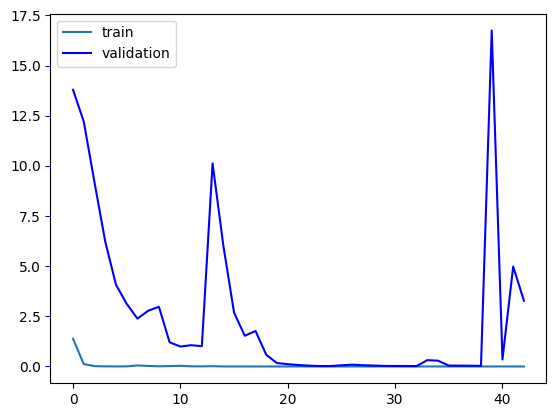

In [18]:
from tensorflow.keras.callbacks import EarlyStopping

model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

early_stopping=EarlyStopping(monitor='val_loss',
                            min_delta=0,
                            patience=10,
                            restore_best_weights=True)

model_hist = model.fit(x_train, y_train,verbose=2,epochs=60,validation_data=(x_vr,y_vr),batch_size=32,callbacks=[early_stopping])

_,axe = plt.subplots()
axe.plot(model_hist.history['loss'], label='train')
axe.tick_params(axis='y',)

axe.plot(model_hist.history['val_loss'],color='b',label='validation')
axe.tick_params(axis='y',color='b')
axe.legend()

plt.show()

loss 겁나 튄다

## 테스트

In [19]:
image_dir_path='rock_scissor_paper/test'

resize_images(image_dir_path + '/rock')
resize_images(image_dir_path + '/scissor')
resize_images(image_dir_path + '/paper')
(X_test, y_test) = load_data(image_dir_path)
X_test_norm = X_test/255.0

100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
학습데이터(x_train)의 이미지 개수는 300 입니다.


In [20]:
test_loss, test_accuracy = model.evaluate(X_test_norm,y_test, verbose=2)
print(f"test_loss: {test_loss}")
print(f"test_accuracy: {test_accuracy}")

10/10 - 1s - loss: 10.6369 - accuracy: 0.5467 - 843ms/epoch - 84ms/step
test_loss: 10.636863708496094
test_accuracy: 0.54666668176651


# 회고

초반에 과적합인 것을 확인하고 바꿔볼 게 머가 있을 까 고민하다가 train 데이터에 학습이 너무 잘되어 있으니 일반화를 조금 해보자는 목적으로 epoch을 10번에서 5번으로 줄였다.그에 따라 test데이터셋에 대한 acurracy가 0.5로 비약적으로 상승했는데, 당연히 정확도가 50프로가 채 안됬어서 과적합을 조금 완화해주었다라고 봐야할 것 같다.

이미지 사이즈를 28에서 128 늘렸고 그에 따라 학습시킬 픽셀 데이터 갯수가 많아져서 정확도 또한 오른 것 같다.

픽셀 사이즈를 224로도 늘려봤는데 128일 때 보다 학습이 잘 안되는 느낌이 들었음.

그래서 layer층을 조금 더 깊게 해봤는데 초반에 학습이 잘 되다가 loss가 훅 뜨기 시작하고 학습이 잘 안됬음. 아무래도 샘플갯수가 작아서 생긴 오퍼피팅 때문이지 않을까하는 생각으로 데이터 변형시켜서 950개까지 늘려봤는데도 비슷했음. 적어도 만개는 되야 층고를 깊게하는 것이 가능하지않을까함. 

이후에 BatchNormal로 중간 중간 정규화도 시켜보고, Dropout으로 과적합 방지시켜보고 해보았지만, 아직 이 층고의 적당한 깊이와 conv2d에서 찾을 특성 수를 어떻게 정해줘야할 지, epoch은 얼마나 줘야할지 정확하게는 모르겠다는 생각이 들었습니다.

그래서 early_stopping으로 실험을 빠르게 진행시켜 이렇게 해보니 잘되더라하는 딥러닝의 특성을 이용해 무수한 실험으로 찾아가게 되었는데 이렇게하는게 좋더라 저렇게 하는게 좋더라 보다는 데이터 샘플 갯수, 픽셀 수 등등 데이터를 먼저 이해하고 그에 맞는 방법들을 찾아가야한다는 생각이 들었습니다.

한 1주일동안 붙잡고 해본 결과 60퍼센트는 넘겼는데 이게 어떻게 올라간건지 정확도를 더 어떻게 올려야할 지는 앞으로 더 알아봐야할 것 같습니다.

## 참고문헌

https://blog.naver.com/PostView.naver?blogId=beyondlegend&logNo=222309644589&parentCategoryNo=&categoryNo=93&viewDate=&isShowPopularPosts=false&from=postView


Cnn성능 개선
https://blog.naver.com/goodji15/222973730819

CNN 층고 깊을수록 좋은이유
https://blog.naver.com/amsdi12/222705520474

dropout을 pooling layer뒤에만 쓴 이유
https://kin.naver.com/qna/detail.naver?d1id=1&dirId=104&docId=429149776&qb=Q05OIOy4tQ==&enc=utf8&section=kin.ext&rank=1&search_sort=0&spq=0

batch normalization
https://shuuki4.wordpress.com/2016/01/13/batch-normalization-%EC%84%A4%EB%AA%85-%EB%B0%8F-%EA%B5%AC%ED%98%84/


과적합 방지기법
https://sacko.tistory.com/44

https://webnautes.tistory.com/1648

layer 배치 순서
https://gaussian37.github.io/dl-concept-order_of_regularization_term/

소규모로 딥러닝할 때
https://m.blog.naver.com/urisystem72/222998323100